# Examine a few Predictions

In [47]:
# imports
import yaml

import torch
import h5py
from torch.utils.data import Dataset
from torch import nn
from tqdm import tqdm

from pytorch3dunet.unet3d.model import get_model
from pytorch3dunet.unet3d.config import load_config
from pytorch3dunet.unet3d import utils
from pytorch3dunet.unet3d.model import UNet2D
import pytorch3dunet.augment.transforms as transforms
from pytorch3dunet.datasets.utils import calculate_stats

from fronts.plotting import images

# Single image DataSet

In [40]:
class ImageDataset(Dataset):
    def __init__(self, raws, transform):
        self.transformer = transform
        self.raw = raws
        self.raw_transform = self.transformer.raw_transform()

    def __len__(self):
        return 1

    def __getitem__(self, global_idx):     
        image = self.raw[global_idx]
        image_transformed = self.raw_transform(image)
        
        return image_transformed

# Needed methods

In [20]:
def _is_2d_model(model):
    if isinstance(model, nn.DataParallel):
        model = model.module
    return isinstance(model, UNet2D)

# Load config

In [8]:
config = yaml.safe_load(open('llc4320_sst144_sss40_train.yml', 'r'))

# Load Model

In [9]:
model = get_model(config['model'])

## Load Model State

In [14]:
#model_path = config['model_path']
#logger.info(f'Loading model from {model_path}...')
_ = utils.load_checkpoint('/home/xavier/Projects/Oceanography/data/OGCM/LLC/Fronts/Unet2D/best_checkpoint.pytorch', model)

## CPU/GPU

In [15]:
if torch.cuda.device_count() > 1 and not config['device'] == 'cpu':
    model = nn.DataParallel(model)
    #logger.info(f'Using {torch.cuda.device_count()} GPUs for prediction')
if torch.cuda.is_available() and not config['device'] == 'cpu':
    model = model.cuda()

# Use valid data

In [21]:
valid_file = '/home/xavier/Projects/Oceanography/data/OGCM/LLC/Fronts/LLC4320_SST144_SSS40_valid.h5'

In [22]:
f = h5py.File(valid_file,'r')

In [61]:
idx = 33
img = f['inputs'][idx:idx+1]
targ = f['targets'][idx:idx+1]
targ.sum()

np.float32(2563.0)

## ImageLoader

In [28]:
transformer_config = config['loaders']['val']['transformer']
stats = calculate_stats(None, True)
transformer = transforms.Transformer(transformer_config, stats)

In [62]:
iDataset = ImageDataset(img, transformer)

In [63]:
test_loader = torch.utils.data.DataLoader(
                    iDataset, batch_size=1,
                    shuffle=False,
                    num_workers=1,
                    pin_memory=False, sampler=None)

# Go for it

In [64]:
_ = model.eval()

In [65]:
with torch.no_grad():
    for input in tqdm(test_loader):
        # send batch to gpu
        if torch.cuda.is_available():
            input = input.pin_memory().cuda(non_blocking=True)

        if _is_2d_model(model):
            # remove the singleton z-dimension from the input
            input = torch.squeeze(input, dim=-3)
            # forward pass
            prediction = model(input)
            # add the singleton z-dimension to the output
            prediction = torch.unsqueeze(prediction, dim=-3)
        else:
            # forward pass
            prediction = model(input)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


In [66]:
prediction.shape

torch.Size([1, 1, 1, 64, 64])

# View it!

<Axes: >

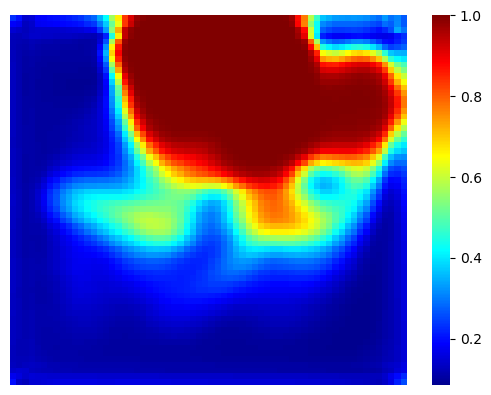

In [67]:
images.show_image(prediction[0,0,0,...])

<Axes: >

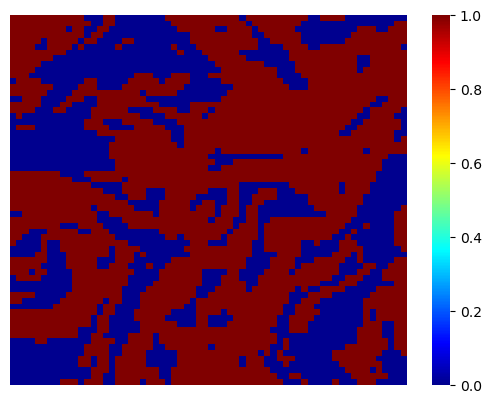

In [69]:
images.show_image(targ[0,0,0,...])